# Carbon FIxation gene analysis from CR17 dataset
### Annotated using the *mi-faser* tool against the GS+ database corrected for the 2-Oxoglutarate:ferredoxin oxidoreductase

In [1]:
import sys
print(sys.executable)


/Users/benoitdepins/miniconda3/envs/py37/bin/python


In [2]:
import igraph

print(igraph.__version__)


0.8.3


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import pdist, squareform
import community as community_louvain
from networkx.algorithms import community
import igraph as ig
from igraph import Graph, plot
import networkx as nx
import cairocffi
#from igraph import *
import random
from scipy import stats
from scipy.stats import pearsonr, spearmanr


In [4]:
ecdata = pd.read_csv("otu.csv")

ecdata.set_index("EC", inplace=True)

ecdata = ecdata.drop(columns=['prt_read_lenght_av'])



In [5]:
ecdata

CR18BCF  BQ170218F  BQ170218S  BQ170218  BR170218_2F  BR170218_1  \
EC                                                                            
1.1.1.1     1175.0     8191.0     8848.0    7199.0       4631.0      1511.0   
1.1.1.10      17.0        NaN        NaN       NaN          6.0         9.0   
1.1.1.100   6054.0     4291.0     5304.0    3802.0      10787.0     11054.0   
1.1.1.103   1660.0       30.0      669.0      36.0       1607.0      1962.0   
1.1.1.107     52.0      144.0      136.0     209.0         42.0       104.0   
...            ...        ...        ...       ...          ...         ...   
7.5.2.8      486.0        NaN       87.0       NaN        412.0        31.0   
7.6.2.1      785.0       26.0      121.0      10.0        481.0       511.0   
7.6.2.2     1264.0      559.0      784.0     415.0       1219.0      1320.0   
7.6.2.8      145.0      371.0      414.0     378.0        311.0       521.0   
7.6.2.9      568.0        3.0       31.0       1.0        357.0       426.0   

           BR170218_2S  CR18BSF  CR18CHF  CR18CHS  ...  SAMN14653546  \
EC                                                 ...                 
1.1.1.1         1547.0  13016.0   1548.0   1085.0  ...        1967.0   
1.1.1.10          41.0    103.0     39.0     24.0  ...          40.0   
1.1.1.100      13673.0  26515.0   9391.0   7281.0  ...       12076.0   
1.1.1.103       3418.0   4539.0   1516.0   1672.0  ...        2533.0   
1.1.1.107        150.0    101.0    130.0     94.0  ...          77.0   
...                ...      ...      ...      ...  ...           ...   
7.5.2.8          144.0   2940.0    956.0    146.0  ...         394.0   
7.6.2.1          804.0    907.0    409.0    353.0  ...         655.0   
7.6.2.2         2076.0   3377.0   1668.0   1251.0  ...        2576.0   
7.6.2.8          669.0   1437.0    181.0    198.0  ...         277.0   
7.6.2.9          325.0   4314.0    664.0    392.0  ...         374.0   

           SAMN14653547  SAMN14653548  SAMN14653549  SAMN14653552  \
EC                                                                  
1.1.1.1          1125.0         799.0        4804.0        1395.0   
1.1.1.10           24.0          25.0           9.0          28.0   
1.1.1.100        6783.0        4983.0        9983.0        6694.0   
1.1.1.103        1344.0        1234.0         390.0         991.0   
1.1.1.107         112.0          60.0          27.0          68.0   
...                 ...           ...           ...           ...   
7.5.2.8           295.0         331.0          94.0         186.0   
7.6.2.1           389.0         349.0         360.0         420.0   
7.6.2.2           998.0         871.0         512.0         998.0   
7.6.2.8           205.0         158.0          94.0         247.0   
7.6.2.9           479.0         290.0         146.0         373.0   

           SAMN14653553  SAMN14653554  SAMN14653555  SAMN14653556  \
EC                                                                  
1.1.1.1           407.0         491.0        1088.0        1960.0   
1.1.1.10            1.0           5.0          39.0          44.0   
1.1.1.100        2111.0       11532.0        9093.0        8131.0   
1.1.1.103         975.0         356.0        3007.0        1561.0   
1.1.1.107           8.0          19.0         162.0          75.0   
...                 ...           ...           ...           ...   
7.5.2.8            23.0          81.0         287.0         451.0   
7.6.2.1            88.0         231.0         553.0         383.0   
7.6.2.2           354.0        1655.0        1659.0        1267.0   
7.6.2.8           100.0         935.0         545.0         229.0   
7.6.2.9            65.0         217.0         718.0         334.0   

           SAMN14653557  
EC                       
1.1.1.1           567.0  
1.1.1.10            7.0  
1.1.1.100        4254.0  
1.1.1.103         931.0  
1.1.1.107          34.0  
...                 ...  
7.5.2.8           269.0  
7.6.2.1         

Normalization

In [6]:
col_sums = ecdata.sum(axis=0, skipna=True)
median_col_sums = np.median(col_sums)
ecdata_n = ecdata.apply(lambda x: (x / x.sum(skipna=True)) * median_col_sums, axis=0)


In [7]:
ecdata_n

CR18BCF     BQ170218F     BQ170218S      BQ170218  BR170218_2F  \
EC                                                                              
1.1.1.1    1068.529498  13074.895880  11850.443294  13278.482011  3238.562315   
1.1.1.10     15.459576           NaN           NaN           NaN     4.195935   
1.1.1.100  5505.427728   6849.515105   7103.837165   7012.750188  7543.591382   
1.1.1.103  1509.582099     47.887544    896.015660     66.401633  1123.811194   
1.1.1.107    47.288114    229.860213    182.149671    385.498366    29.371543   
...                ...           ...           ...           ...          ...   
7.5.2.8     441.961988           NaN    116.522216           NaN   288.120854   
7.6.2.1     713.868643     41.502539    162.059634     18.444898   336.374104   
7.6.2.2    1149.464924    892.304578   1050.039279    765.463264   852.474079   
7.6.2.8     131.861087    592.209299    554.485028    697.217141   217.489285   
7.6.2.9     516.531706      4.788754     41.519410      1.844490   249.658118   

            BR170218_1  BR170218_2S      CR18BSF      CR18CHF      CR18CHS  \
EC                                                                           
1.1.1.1    1220.708424   831.155024  4210.605726  1206.570695  1207.694537   
1.1.1.10      7.270930    22.028026    33.319944    30.398099    26.713981   
1.1.1.100  8930.318275  7346.077984  8577.459343  7319.706329  8104.353849   
1.1.1.103  1585.062824  1836.385179  1468.341994  1181.628665  1861.073978   
1.1.1.107    84.019640    80.590338    32.672955   101.326996   104.629757   
...                ...          ...          ...          ...          ...   
7.5.2.8      25.044316    77.366725   951.074127   745.143142   162.510048   
7.6.2.1     412.827270   431.964214   293.409603   318.790319   392.918131   
7.6.2.2    1066.403123  1115.370284  1092.441267  1300.103307  1392.466236   
7.6.2.8     420.906081   359.432909   464.861742   141.078356   220.390340   
7.6.2.9     344.157372   174.612400  1395.555708   517.547120   436.328349   

           ...  SAMN14653546  SAMN14653547  SAMN14653548  SAMN14653549  \
EC         ...                                                           
1.1.1.1    ...   1096.338114   1338.544671   1138.285766   4841.274569   
1.1.1.10   ...     22.294624     28.555620     35.615950      9.069832   
1.1.1.100  ...   6730.746855   8070.532002   7098.971178  10060.458790   
1.1.1.103  ...   1411.807037   1599.114700   1758.003298    393.026037   
1.1.1.107  ...     42.917150    133.259558     85.478280     27.209495   
...        ...           ...           ...           ...           ...   
7.5.2.8    ...    219.602042    350.996158    471.555180     94.729353   
7.6.2.1    ...    365.074461    462.839002    497.198664    362.793265   
7.6.2.2    ...   1435.773758   1187.437850   1240.859702    515.972644   
7.6.2.8    ...    154.390268    243.912584    225.092805     94.729353   
7.6.2.9    ...    208.454730    569.922575    413.145021    147.132824   

           SAMN14653552  SAMN14653553  SAMN14653554  SAMN14653555  \
EC                                                                  
1.1.1.1     1815.251342   1186.588352    322.922445    726.928318   
1.1.1.10      36.435152      2.915450      3.288416     26.057173   
1.1.1.100   8710.603929   6154.515998   7584.402506   6075.330144   
1.1.1.103   1289.544143   2842.564234    234.135214   2009.074864   
1.1.1.107     88.485370     23.323604     12.495981    108.237489   
...                 ...           ...           ...           ...   
7.5.2.8      242.033512     67.055361     53.272338    191.754069   
7.6.2.1      546.527286    256.559644    151.924816    369.477353   
7.6.2.2     1298.652931   1032.069476   1088.465674   1108.432059   
7.6.2.8      321.410094    291.545050    614.933779    364.132292   
7.6.2.9      485.368280    189.504282    142.717251    479.719239   

           SAMN14653556  SAMN14653557  
EC                                     
1.1.1

Select only carbon associated genes

In [13]:
ec_list = pd.read_csv("Carbon_EC_numbers - Pathways_overlap.csv").EC.values.flatten()
dataset_carbon = ecdata_n.loc[ecdata_n.index.isin(ec_list)]

In [18]:
len(set(ec_list))

149

In [25]:
dataset_carbon

CR18BCF     BQ170218F    BQ170218S      BQ170218  BR170218_2F  \
EC                                                                             
1.1.1.27    560.182273     59.061305   278.581850     40.578775   417.495509   
1.1.1.29     20.915897      1.596251     1.339336           NaN    11.888482   
1.1.1.35    903.930486    890.708326  1127.720757   1128.827753  1338.503189   
1.1.1.363    41.831793      3.192503    17.411366           NaN    16.084417   
1.1.1.37   3662.100671  11421.179346  9056.588783  10557.859568  3751.865001   
...                ...           ...          ...           ...          ...   
6.2.1.5    4267.752284  10934.322644  9474.461558  11151.785281  5319.046635   
6.3.4.3    3518.417555     20.751269  1198.705555     47.956735  2053.210744   
6.4.1.1    3758.495672     31.925030   800.922818      5.533469  2702.881310   
6.4.1.2    6394.808025     87.793831  1642.025710     20.289388  5387.580236   
6.4.1.3    3818.515201     68.638814   748.688721     36.889796  1722.431220   

            BR170218_1  BR170218_2S      CR18BSF      CR18CHF      CR18CHS  \
EC                                                                           
1.1.1.27   1033.279996   703.285020  1166.198036   380.365956   596.612232   
1.1.1.29      2.423643    23.639833     5.499408   106.783065    84.594272   
1.1.1.35    724.669395  1071.851501  1583.829566  1586.157212  1036.279829   
1.1.1.363    41.201939    20.416219    38.819352    56.899006    82.368107   
1.1.1.37   5100.961606  5020.240817  3772.270541  3749.098865  4347.700334   
...                ...          ...          ...          ...          ...   
6.2.1.5    3859.248272  4792.438793  5802.199162  5822.405098  5233.714023   
6.3.4.3    3920.647240  4484.046431  2423.945045  2821.567129  3531.810845   
6.4.1.1    2577.948762  2757.264113  4196.695458  3745.981111  1937.876672   
6.4.1.2    6446.083727  6239.304003  4997.021100  5367.992491  5050.055406   
6.4.1.3    2636.116205  3049.001138  2971.944899  4515.286845  2980.834996   

           ...  SAMN14653546  SAMN14653547  SAMN14653548  SAMN14653549  \
EC         ...                                                           
1.1.1.27   ...    180.029085    467.598272    723.716106     94.729353   
1.1.1.29   ...     15.048871     10.708357     21.369570      5.038795   
1.1.1.35   ...   1528.296446   1254.067629   1218.065494   1892.571532   
1.1.1.363  ...     27.310914     77.338137     55.560882     20.155181   
1.1.1.37   ...   4846.293798   4467.764657   4528.924217   3819.406873   
...        ...           ...           ...           ...           ...   
6.2.1.5    ...   5220.286108   4986.525081   4852.317045   6791.288369   
6.3.4.3    ...   2244.511228   5186.414418   4917.850393   1029.929769   
6.4.1.1    ...   1955.795852   2041.726805   2276.571532   1841.175820   
6.4.1.2    ...   5633.851376   4586.746406   4631.498154   4687.087432   
6.4.1.3    ...   3219.343643   3150.636701   3514.581958   1661.794705   

           SAMN14653552  SAMN14653553  SAMN14653554  SAMN14653555  \
EC                                                                  
1.1.1.27     774.246988    545.189243     71.687467    513.794004   
1.1.1.29      15.615065           NaN     10.522931     18.707714   
1.1.1.35    1588.832895    740.524426   5087.179447    829.820745   
1.1.1.363    100.196669     43.731757     49.326239     17.371449   
1.1.1.37    5326.038524   4982.504898   3473.224908   3996.101352   
...                 ...           ...           ...           ...   
6.2.1.5     4741.774831   3950.435422   4491.976163   4238.633502   
6.3.4.3     4106.762175   4157.432408    637.952691   5224.797286   
6.4.1.1     2724.828896   2099.124357    580.076570   1948.942926   
6.4.1.2     5514.720563   5139.939225   5677.121265   5091.838890   
6.4.1.3     2903.100891   1909.620075   6084.227158   2375.879687   

           SAMN14653556  SAMN14653557  
EC                                     
1.1.1.27     479.0

Prepare the matrix

In [58]:
# Count the number of NaN values in each row
nan_counts = dataset_carbon.isna().sum(axis=1)

# Get the index of the row(s) with the maximum number of NaN values
max_nan_index = nan_counts.idxmax()

# If there are multiple rows with the same max number of NaNs, you can get all their indices like this:
max_nan_indices = nan_counts[nan_counts == nan_counts.max()].index


In [60]:
# Count the number of NaN values in each row
nan_counts = dataset_carbon.isna().sum(axis=1)

# Get the maximum number of NaN values
max_nan_count = nan_counts.max()

# Get the indices of the rows with the maximum number of NaN values
max_nan_indices = nan_counts[nan_counts == max_nan_count].index

# Print the indices and the count of NaNs
print("Indices of rows with the highest number of NaN values:")
for idx in max_nan_indices:
    print(f"Index: {idx}, Number of NaNs: {max_nan_count}")


Indices of rows with the highest number of NaN values:
Index: 2.1.1.146, Number of NaNs: 290


In [72]:
dataset_complete = dataset_carbon#.dropna(axis=1, how='any') #because we have some missing data
#dataset_complete.index.name = None


cor_matrix = dataset_complete.T.corr(method='spearman')
cor_matrix[cor_matrix < 0.6] = 0

In [73]:
cor_matrix

EC         1.1.1.27  1.1.1.29  1.1.1.35  1.1.1.363  1.1.1.37  1.1.1.40  \
EC                                                                       
1.1.1.27        1.0       0.0       0.0        0.0       0.0       0.0   
1.1.1.29        0.0       1.0       0.0        0.0       0.0       0.0   
1.1.1.35        0.0       0.0       1.0        0.0       0.0       0.0   
1.1.1.363       0.0       0.0       0.0        1.0       0.0       0.0   
1.1.1.37        0.0       0.0       0.0        0.0       1.0       0.0   
...             ...       ...       ...        ...       ...       ...   
6.2.1.5         0.0       0.0       0.0        0.0       0.0       0.0   
6.3.4.3         0.0       0.0       0.0        0.0       0.0       0.0   
6.4.1.1         0.0       0.0       0.0        0.0       0.0       0.0   
6.4.1.2         0.0       0.0       0.0        0.0       0.0       0.0   
6.4.1.3         0.0       0.0       0.0        0.0       0.0       0.0   

EC         1.1.1.41  1.1.1.42  1.1.1.49  1.1.1.82  ...  5.4.2.11  5.4.2.12  \
EC                                                 ...                       
1.1.1.27   0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
1.1.1.29   0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
1.1.1.35   0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
1.1.1.363  0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
1.1.1.37   0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
...             ...       ...       ...       ...  ...       ...       ...   
6.2.1.5    0.000000  0.633448       0.0       0.0  ...       0.0       0.0   
6.3.4.3    0.651753  0.000000       0.0       0.0  ...       0.0       0.0   
6.4.1.1    0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
6.4.1.2    0.000000  0.000000       0.0       0.0  ...       0.0       0.0   
6.4.1.3    0.000000  0.000000       0.0       0.0  ...       0.0       0.0   

EC         5.4.99.2  6.2.1.1  6.2.1.4  6.2.1.5  6.3.4.3  6.4.1.1  6.4.1.2  \
EC                                                                          
1.1.1.27        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.29        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.35        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.363       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.37        0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...             ...      ...      ...      ...      ...      ...      ...   
6.2.1.5         0.0      0.0      0.0      1.0      0.0      0.0      0.0   
6.3.4.3         0.0      0.0      0.0      0.0      1.0      0.0      0.0   
6.4.1.1         0.0      0.0      0.0      0.0      0.0      1.0      0.0   
6.4.1.2         0.0      0.0      0.0      0.0      0.0      0.0      1.0   
6.4.1.3         0.0      0.0      0.0      0.0      0.0      0.0      0.0   

EC         6.4.1.3  
EC                  
1.1.1.27       0.0  
1.1.1.29       0.0  
1.1.1.35       0.0  
1.1.1.363      0.0  
1.1.1.37       0.0  
...            ...  
6.2.1.5        0.0  
6.3.4.3        0.0  
6.4.1.1        0.0  
6.4.1.2        0.0  
6.4.1.3        1.0  

[99 rows x 99 columns]

In [74]:
# Set diagonal to 0 temporarily
np.fill_diagonal(cor_matrix.values, 0)

# Remove rows and columns that sum to 0
cor_matrix = cor_matrix.loc[(cor_matrix.sum(axis=1) != 0), (cor_matrix.sum(axis=0) != 0)]

# Restore the diagonal to 1
np.fill_diagonal(cor_matrix.values, 1)

In [91]:
cor_matrix

EC         1.1.1.27  1.1.1.29  1.1.1.35  1.1.1.363  1.1.1.37  1.1.1.40  \
EC                                                                       
1.1.1.27        0.0       0.0       0.0        0.0       0.0       0.0   
1.1.1.29        0.0       0.0       0.0        0.0       0.0       0.0   
1.1.1.35        0.0       0.0       0.0        0.0       0.0       0.0   
1.1.1.363       0.0       0.0       0.0        0.0       0.0       0.0   
1.1.1.37        0.0       0.0       0.0        0.0       0.0       0.0   
...             ...       ...       ...        ...       ...       ...   
6.2.1.4         0.0       0.0       0.0        0.0       0.0       0.0   
6.2.1.5         0.0       0.0       0.0        0.0       0.0       0.0   
6.3.4.3         0.0       0.0       0.0        0.0       0.0       0.0   
6.4.1.2         0.0       0.0       0.0        0.0       0.0       0.0   
6.4.1.3         0.0       0.0       0.0        0.0       0.0       0.0   

EC         1.1.1.41  1.1.1.42  1.1.2.7  1.12.98.2  ...  5.3.1.27  5.3.1.9  \
EC                                                 ...                      
1.1.1.27   0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
1.1.1.29   0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
1.1.1.35   0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
1.1.1.363  0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
1.1.1.37   0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
...             ...       ...      ...        ...  ...       ...      ...   
6.2.1.4    0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
6.2.1.5    0.000000  0.633448      0.0        0.0  ...       0.0      0.0   
6.3.4.3    0.651753  0.000000      0.0        0.0  ...       0.0      0.0   
6.4.1.2    0.000000  0.000000      0.0        0.0  ...       0.0      0.0   
6.4.1.3    0.000000  0.000000      0.0        0.0  ...       0.0      0.0   

EC         5.3.3.3  5.4.2.11  6.2.1.1  6.2.1.4  6.2.1.5  6.3.4.3  6.4.1.2  \
EC                                                                          
1.1.1.27       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.29       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.35       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.363      0.0       0.0      0.0      0.0      0.0      0.0      0.0   
1.1.1.37       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
...            ...       ...      ...      ...      ...      ...      ...   
6.2.1.4        0.0       0.0      0.0      0.0      0.0      0.0      0.0   
6.2.1.5        0.0       0.0      0.0      0.0      0.0      0.0      0.0   
6.3.4.3        0.0       0.0      0.0      0.0      0.0      0.0      0.0   
6.4.1.2        0.0       0.0      0.0      0.0      0.0      0.0      0.0   
6.4.1.3        0.0       0.0      0.0      0.0      0.0      0.0      0.0   

EC         6.4.1.3  
EC                  
1.1.1.27       0.0  
1.1.1.29       0.0  
1.1.1.35       0.0  
1.1.1.363      0.0  
1.1.1.37       0.0  
...            ...  
6.2.1.4        0.0  
6.2.1.5        0.0  
6.3.4.3        0.0  
6.4.1.2        0.0  
6.4.1.3        0.0  

[74 rows x 74 columns]

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import umap
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import to_rgba

# Load your correlation matrix
cor_matrix = pd.read_csv('cor_matrix.csv', index_col=0)

# Load the pathway data
pathways_df = pd.read_csv('Carbon_EC_numbers - Pathways_overlap.csv')

# Create a color map for pathways
unique_pathways = pathways_df['pathway'].unique()
color_map = {pathway: sns.color_palette("hsv", len(unique_pathways))[i] for i, pathway in enumerate(unique_pathways)}

# Assign colors to each EC number based on its pathway
def assign_colors(ec_number):
    pathways = pathways_df[pathways_df['EC'] == ec_number]['pathway'].values
    colors = [color_map[pathway] for pathway in pathways]
    return colors

# Calculate UMAP, PCA, t-SNE, and MDS embeddings
def plot_embeddings(embeddings, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    for idx, ec_number in enumerate(cor_matrix.index):
        colors = assign_colors(ec_number)
        if len(colors) > 1:
            wedges, _ = ax.pie([1] * len(colors), center=embeddings[idx], colors=[to_rgba(c) for c in colors], radius=0.02)
        else:
            ax.scatter(embeddings[idx, 0], embeddings[idx, 1], color=colors[0], s=100)
    ax.set_title(title)
    plt.show()

# UMAP
umap_embedding = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(cor_matrix)
plot_embeddings(umap_embedding, 'UMAP')

# PCA
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(cor_matrix)
plot_embeddings(pca_embedding, 'PCA')

# t-SNE
tsne_embedding = TSNE(n_components=2, random_state=42).fit_transform(cor_matrix)
plot_embeddings(tsne_embedding, 't-SNE')

# MDS
mds = MDS(n_components=2, random_state=42)
mds_embedding = mds.fit_transform(cor_matrix)
plot_embeddings(mds_embedding, 'MDS')


ModuleNotFoundError: No module named 'importlib.metadata'

Plot with igraph

In [81]:
pathway_df.pathway.unique()

array(['3HBC', 'C1', 'C4', 'CAM', 'CBB', 'DCHB', 'Gluconeogenesis',
       'Glycolysis', 'HPHB', 'InrTCA', 'Methanogenesis', 'PPP', 'rTCA',
       'TCA', 'WL'], dtype=object)

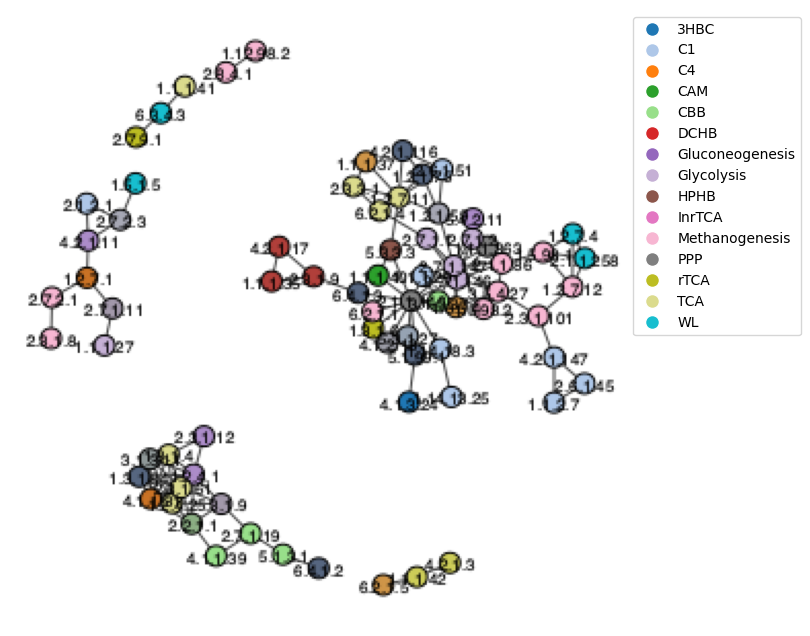

In [90]:
import pandas as pd
import igraph as ig
import random
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
from PIL import Image

# Load the pathway data
pathway_df = pd.read_csv("Carbon_EC_numbers - Pathways_overlap.csv")

# Create a dictionary mapping EC numbers to pathways
ec_to_pathways = pathway_df.groupby('EC')['pathway'].apply(list).to_dict()

# Define the list of possible pathways
possible_pathways = ['3HBC', 'C1', 'C4', 'CAM', 'CBB', 'DCHB', 'Gluconeogenesis',
                     'Glycolysis', 'HPHB', 'InrTCA', 'Methanogenesis', 'PPP', 'rTCA',
                     'TCA', 'WL']

# Use a specific colormap for distinct colors
cmap = plt.get_cmap('tab20')
color_map = {pathway: cmap(i / len(possible_pathways)) for i, pathway in enumerate(possible_pathways)}


# Function to mix colors if an EC number is associated with multiple pathways
def mix_colors(colors):
    return tuple(sum(x) / len(x) for x in zip(*colors))

# Assign colors to vertices based on their associated pathways
vertex_colors = []
for ec in cor_matrix.index:
    if ec in ec_to_pathways:
        pathways = ec_to_pathways[ec]
        if len(pathways) > 1:
            mixed_color = mix_colors([color_map[path] for path in pathways])
            vertex_colors.append(mcolors.to_hex(mixed_color))
        else:
            vertex_colors.append(mcolors.to_hex(color_map[pathways[0]]))
    else:
        vertex_colors.append("#000000")  # Default to black if no pathway is found

# Create the graph from the matrix
bac_cor_ig = ig.Graph.Adjacency((cor_matrix.values > 0).tolist(), mode="undirected")
bac_cor_ig.es['weight'] = cor_matrix.values[cor_matrix.values > 0]

# Simplify the graph to remove loops and multiple edges
bac_cor_ig = bac_cor_ig.simplify()

# Set the vertex colors
bac_cor_ig.vs['color'] = vertex_colors

# Plot the graph to a temporary file
layout = bac_cor_ig.layout("kk")  # Using the Kamada-Kawai layout
graph_plot_path = "/tmp/graph_plot.png"

random.seed(28)
ig.plot(bac_cor_ig, layout=layout, vertex_size=10, bbox=(300, 300), vertex_label=cor_matrix.index, 
        vertex_label_size=8).save(graph_plot_path)

# Load the graph plot image
graph_img = Image.open(graph_plot_path)

# Plot the graph image and the legend together
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(graph_img)
ax.axis('off')  # Turn off the axis

# Create a legend using matplotlib
legend_elements = [Line2D([0], [0], marker='o', color='w', label=pathway, 
                          markerfacecolor=mcolors.to_hex(color_map[pathway]), markersize=10)
                   for pathway in possible_pathways]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


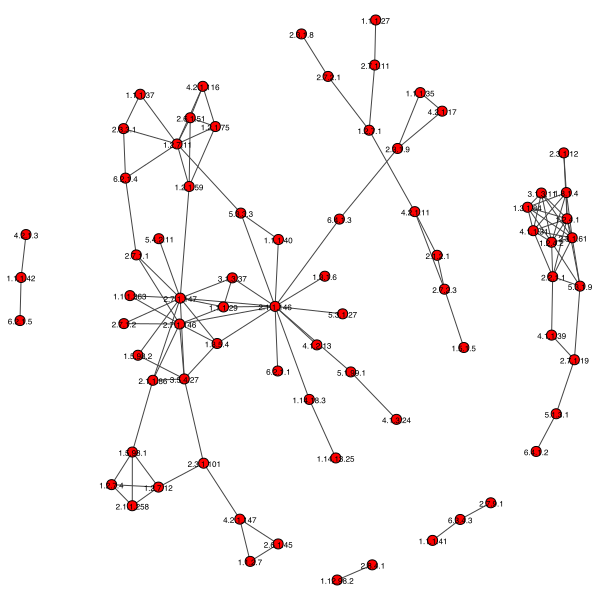

In [78]:
# Create the graph from the matrix
bac_cor_ig = ig.Graph.Adjacency((cor_matrix.values > 0).tolist(), mode="undirected")
bac_cor_ig.es['weight'] = cor_matrix.values[cor_matrix.values > 0]

# Simplify the graph to remove loops and multiple edges
bac_cor_ig = bac_cor_ig.simplify()

# Plot the graph
random.seed(28)
ig.plot(bac_cor_ig, vertex_size=10, bbox=(600,600), vertex_label=cor_matrix.index, vertex_label_size=8)


Plot without igraph (weird)

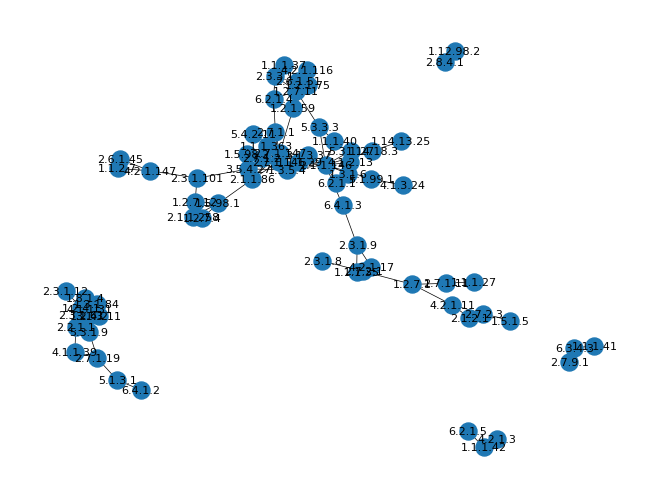

In [77]:

np.fill_diagonal(cor_matrix.values, 0) # to remove self-loops


labels = {i: cor_matrix.index[i] for i in range(len(cor_matrix.index))}


G = nx.from_numpy_array(cor_matrix.values, create_using=nx.Graph)



pos = nx.spring_layout(G, seed=200)  #, k=0.15, iterations=50)

nx.draw(G, pos, labels=labels, with_labels=labels, node_size=150, width=0.5, font_size=8)

plt.show()


Network statistics

In [26]:
num_edges = bac_cor_ig.ecount()
num_nodes = bac_cor_ig.vcount()
assortativity = bac_cor_ig.assortativity_degree()

print(f"Number of edges: {num_edges}")
print(f"Number of nodes: {num_nodes}")
print(f"Assortativity coefficient: {assortativity}")

Number of edges: 241
Number of nodes: 52
Assortativity coefficient: 0.3351588916478428


In [20]:
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
assortativity = nx.degree_assortativity_coefficient(G)

print(f'Number of edges: {num_edges}')
print(f'Number of nodes: {num_nodes}')
print(f'Assortativity coefficient: {assortativity}')

Number of edges: 241
Number of nodes: 52
Assortativity coefficient: 0.33515889164784257


Identify cliques using Louvain

Modularity: 0.4543212766724136


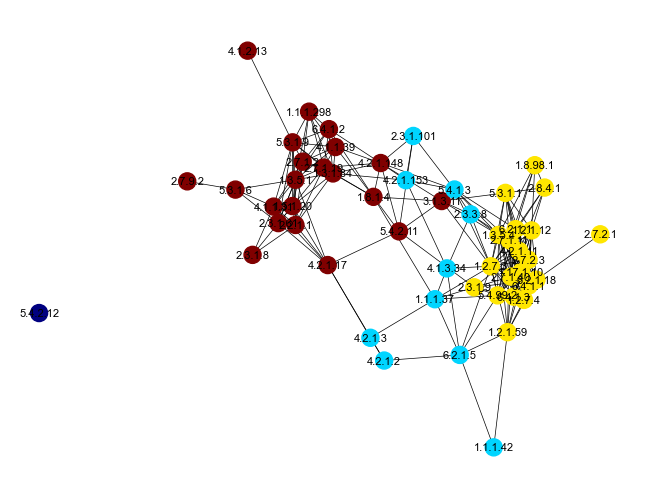

In [385]:
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
print(f'Modularity: {modularity}')

# Add color based on community
colors = [partition[node] for node in G.nodes()]

# plot
pos = nx.spring_layout(G, seed=200)  # positions for all nodes

nx.draw(G, pos, node_color=colors, with_labels=True, labels=labels, node_size=150, width=0.5, font_size=8, cmap=plt.cm.jet)
plt.show()

0.4665295019025155


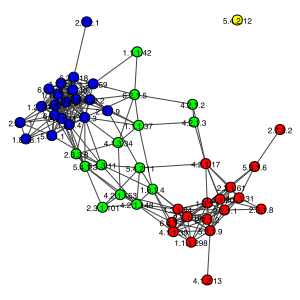

In [35]:
louvain_communities = bac_cor_ig.community_multilevel()

# Modularity
modularity_score = louvain_communities.modularity
print(modularity_score)

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = louvain_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)



Identify cliques using Greedy clustering

Modularity: 0.4241028177413346


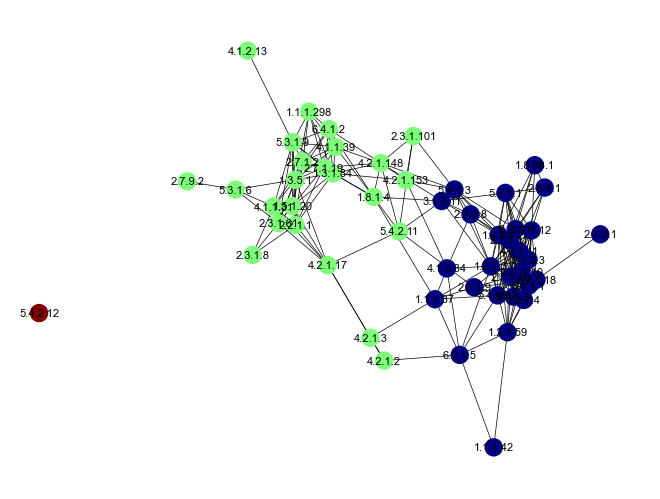

In [384]:
greedy_communities = community.greedy_modularity_communities(G)
greedy_partition = {node: i for i, comm in enumerate(greedy_communities) for node in comm}
modularity = community.modularity(G, greedy_communities)
print(f'Modularity: {modularity}')

# Add color based on community
colors = [greedy_partition[node] for node in G.nodes()]

# plot
pos = nx.spring_layout(G, seed=200)  # positions for all nodes

nx.draw(G, pos, node_color=colors, with_labels=labels, labels=labels, width=0.5, node_size=150, font_size=8, cmap=plt.cm.jet)
#nx.draw(G, pos, labels=labels, with_labels=labels, node_size=150, width=0.5, font_size=8)

#plt.savefig("carbon_greedy_network_cliques.svg", format='svg')
plt.show()

0.41909574559666674


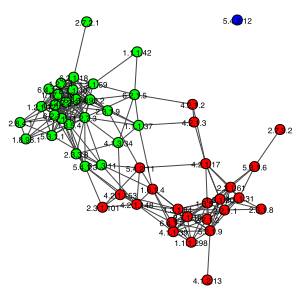

In [40]:

# Identify cliques using Greedy clustering
dendrogram = bac_cor_ig.community_fastgreedy()
greedy_communities = dendrogram.as_clustering()

# Modularity
modularity_score = greedy_communities.modularity
print(modularity_score)

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = greedy_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

# Plot the graph
random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)



Modularity: 0.4175634028339732


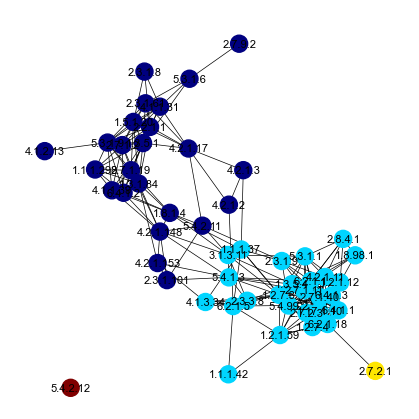

In [398]:

# Convert NetworkX graph to igraph graph
G_igraph = ig.Graph.from_networkx(G)

# Identify communities using Fast Greedy clustering
fast_greedy = G_igraph.community_fastgreedy()
# Get the community structure at the desired level
# The number of clusters (k) is chosen. Adjust as needed.
k = 4  # Number of desired communities (adjust as needed)
communities = fast_greedy.as_clustering(k)

# Compute modularity
modularity = G_igraph.modularity(communities)
print(f'Modularity: {modularity}')

# Map communities to colors
membership = communities.membership
colors = [membership[node] for node in G_igraph.vs.indices]

# Convert igraph layout to NetworkX format
layout = G_igraph.layout("fr")  # Fruchterman-Reingold layout

# Convert layout from igraph to NetworkX format
pos = {i: (layout[i][0], layout[i][1]) for i in range(len(layout))}

# Draw the graph using NetworkX with igraph layout
plt.figure(figsize=(4, 4))

nx.draw(G, pos, node_color=colors, with_labels=labels, labels=labels, width=0.5, node_size=150, font_size=8, cmap=plt.cm.jet)
#plt.savefig("carbon_network_cliques.svg", format='svg')
plt.show()


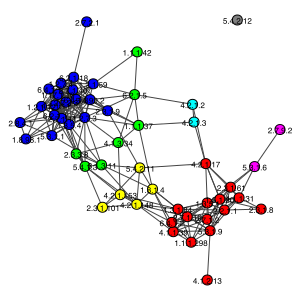

In [41]:
# Identify cliques using Walktrap
walktrap_communities = bac_cor_ig.community_walktrap().as_clustering()

# Modularity
modularity_score = walktrap_communities.modularity

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = walktrap_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

# Plot the graph
random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)

In [42]:
louvain_sizes = louvain_communities.sizes()
greedy_sizes = greedy_communities.sizes()
walktrap_sizes = walktrap_communities.sizes()

print("Louvain community sizes:", louvain_sizes)
print("Greedy community sizes:", greedy_sizes)
print("Walktrap community sizes:", walktrap_sizes)

Louvain community sizes: [17, 14, 20, 1]
Greedy community sizes: [24, 27, 1]
Walktrap community sizes: [15, 7, 20, 5, 2, 2, 1]


## Testing Louvain cliques against the environmental parameters

In [139]:
#clique 1: CBB
#clique 2: rTCA
#clique 3: WL
#clique 4: PGM (glycolysis)

In [48]:
# Assigning cor_matrix.index as the ASV identifiers for the vertices
bac_cor_ig.vs['ASV_id'] = cor_matrix.index

# Extracting the list of ASVs for the main cliques identified by the Louvain function
bac_cor_group1 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 0]
bac_cor_group2 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 1]
bac_cor_group3 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 2]
bac_cor_group4 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 3]

# Print the lists of ASVs
print("Group 1 ASVs :", bac_cor_group1)
print("Group 2 ASVs:", bac_cor_group2)
print("Group 3 ASVs:", bac_cor_group3)
print("Group 4 ASVs:", bac_cor_group4)


Group 1 ASVs: ['1.1.1.298', '1.3.1.84', '1.3.5.1', '1.5.1.20', '2.2.1.1', '2.3.1.61', '2.3.1.8', '2.7.1.19', '2.7.1.2', '2.7.9.2', '4.1.1.31', '4.1.1.39', '4.1.2.13', '4.2.1.17', '5.3.1.6', '5.3.1.9', '6.4.1.2']
Group 2 ASVs: ['1.1.1.37', '1.1.1.42', '1.8.1.4', '2.3.1.101', '2.3.3.8', '3.1.3.11', '4.1.3.34', '4.2.1.148', '4.2.1.153', '4.2.1.2', '4.2.1.3', '5.4.1.3', '5.4.2.11', '6.2.1.5']
Group 3 ASVs: ['1.17.1.10', '1.2.1.12', '1.2.1.59', '1.2.7.3', '1.2.7.4', '1.3.5.4', '1.8.98.1', '2.3.1.9', '2.7.1.11', '2.7.1.40', '2.7.2.1', '2.7.2.3', '2.8.4.1', '4.2.1.11', '5.3.1.1', '5.4.99.2', '6.2.1.1', '6.2.1.18', '6.4.1.1', '6.4.1.3']
Group 4 ASVs: ['5.4.2.12']


subsetting cliques

In [50]:
clique1 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group1)]
clique2 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group2)]
clique3 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group3)]
clique4 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group4)]

col_sums_clique1 = clique1.sum(axis=0)
col_sums_clique2 = clique2.sum(axis=0)
col_sums_clique3 = clique3.sum(axis=0)
col_sums_clique4 = clique4.sum(axis=0)

In [187]:
print(col_sums_clique1.index.tolist())
print(col_sums_clique2.index.tolist())
print(col_sums_clique3.index.tolist())
print(col_sums_clique4.index.tolist())

['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']


In [188]:
# Load the environmental data
envdata = pd.read_csv("subductCR_final_dataset.csv", index_col="code")

print(envdata.index.tolist())


['BQ', 'BQ', 'BQ', 'BR1', 'BR1', 'BR2', 'BR1', 'BR2', 'CY', 'CY', 'EP', 'EP', 'ES1', 'ET1', 'FA1', 'MT', 'PB', 'QH2', 'QH1', 'QH2', 'QN', 'QN', 'RS', 'RS', 'RV', 'SI', 'SI', 'SL', 'SL', 'TC1', 'TC1']


In [189]:
#ADDED BY BENOIT: add the col_sums of each clique in a new col (OK to do so because the indexes match between the envdata dataframe and all the col_sums_clique series)
envdata["sums_clique1"] = col_sums_clique1.values
envdata["sums_clique2"] = col_sums_clique2.values
envdata["sums_clique3"] = col_sums_clique3.values
envdata["sums_clique4"] = col_sums_clique4.values

test: plot clique X against dic

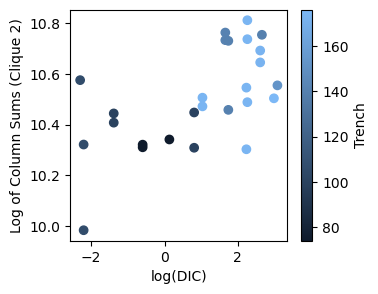

Spearman correlation coefficient (rho): 0.5845483060289691
P-value: 0.0017126087498798804


In [190]:
plt.figure(figsize=(3.5, 3))  

cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_blues',
    ['#0f1b2cff', '#7cb8f6ff']
)

# Scatter plot with color based on 'trench'
scatter = plt.scatter(np.log(envdata['dic']), np.log(envdata['sums_clique2']), c=envdata['trench'], cmap=cmap)


# Add colorbar
plt.colorbar(scatter, label='Trench')

#plt.xscale('log')
plt.xlabel('log(DIC)')
plt.ylabel('Log of Column Sums (Clique 2)')
plt.show()

# Calculate Spearman correlation
rho, p_value = spearmanr(np.log(clean_data['dic']), np.log(clean_data['sums_clique2']))

print(f"Spearman correlation coefficient (rho): {rho}")
print(f"P-value: {p_value}")

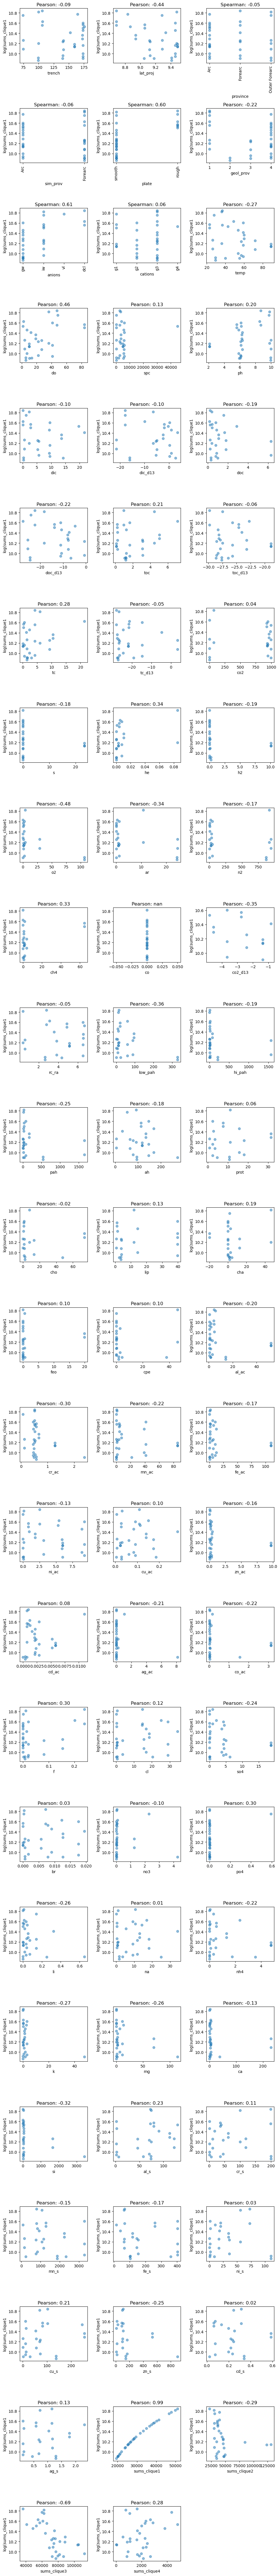

In [135]:
clique = 'clique1'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


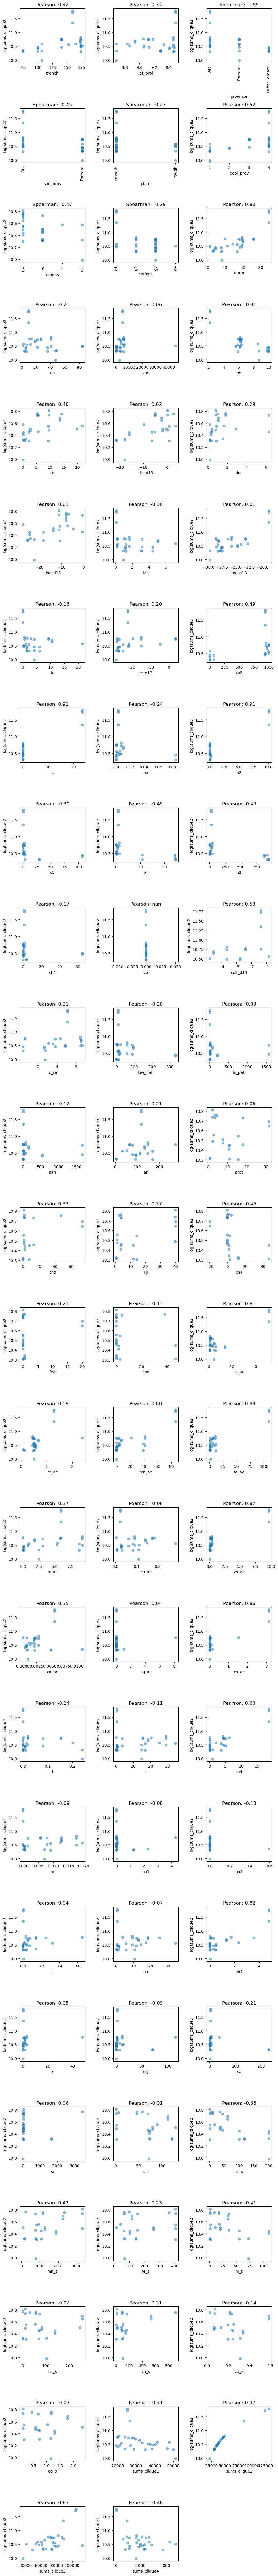

In [136]:
clique = 'clique2'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


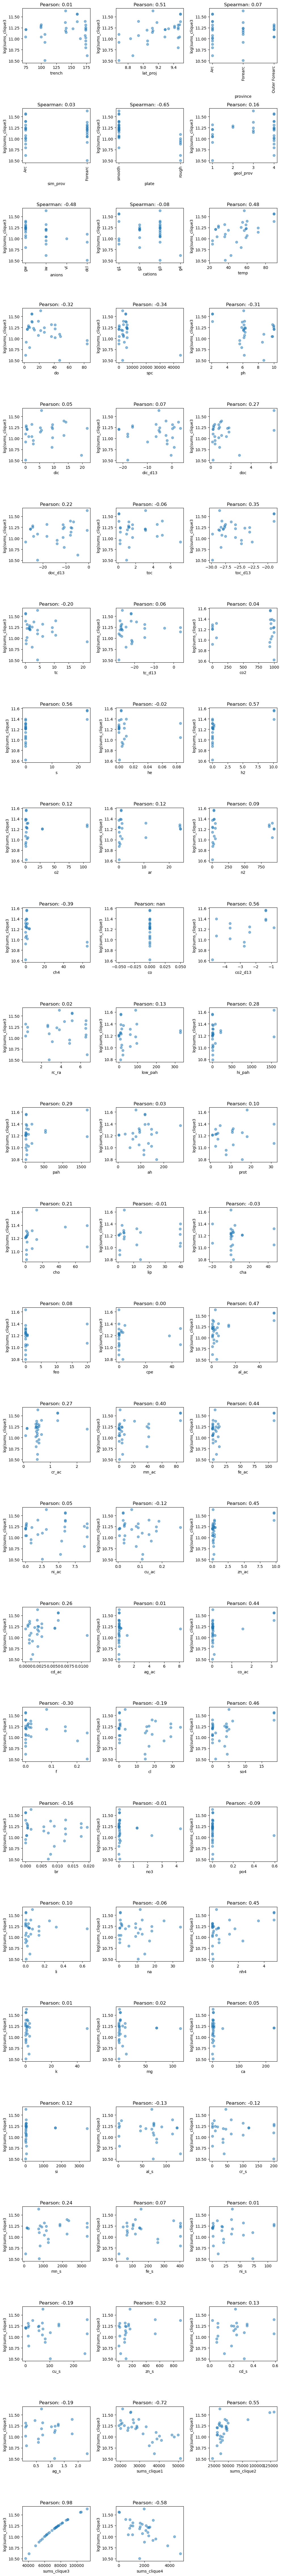

In [137]:
clique = 'clique3'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


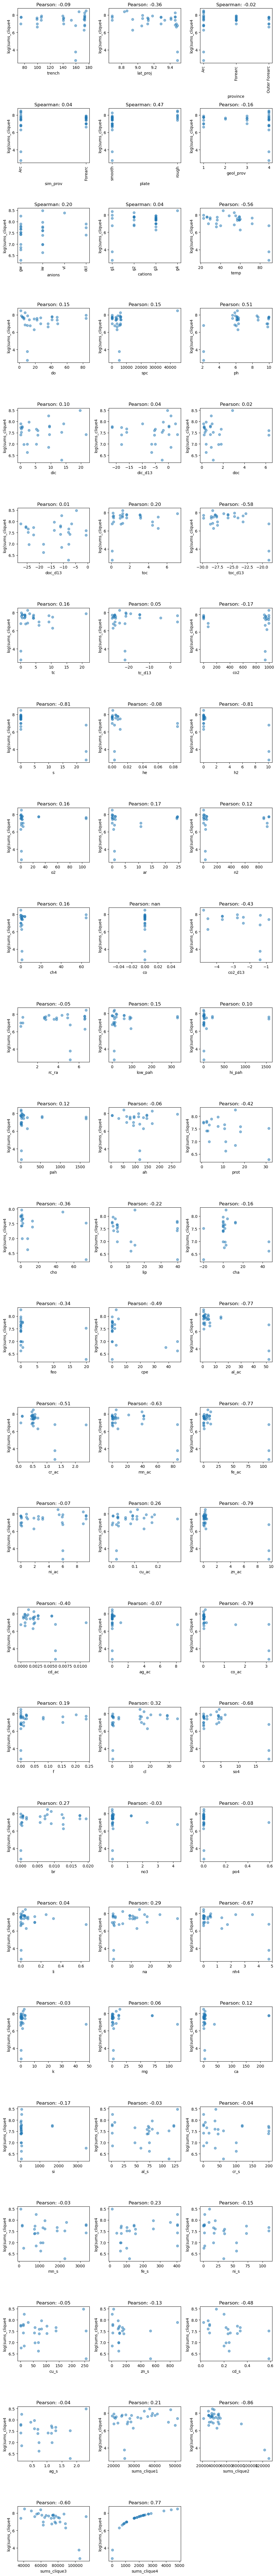

In [138]:
clique = 'clique4'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
